# Предварительная подготовка

## Подключение Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Импорт библиотек

In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

from matplotlib import pyplot as plt

from collections import defaultdict
from math import ceil
import time

import torch
import torch.cuda
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Параметры и константы

Для избежания влияния фактора случайности seed задается вручную

In [5]:
torch.manual_seed(0)

In [80]:
DATA_PATH = "/content/drive/MyDrive/datasets/ready2020.csv"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
NUM_BATCHES = 20
EPOCHS = 50

## Определение задачи и метрик

Задачей текущей работы является определение тональности текстов пользовательских отзывов или, другими словами, задачей является бинарная (что будет рассмотрено далее) классификация текстов.

В качестве метрик эффективности логично будут использоваться:

1.   Accuracy.

2.   Различные варианты f1.

3.   Время, затраченное на обучение модели.


# Загрузка и описание набора данных

In [ ]:
df = pd.read_csv(DATA_PATH, sep=";", index_col=0)
df

,date,name,stars,text,X,Y,status
1,29 марта 2020,ЯНатка,2.0,Были на экскурсии. Я очень люблю производствен...,37.599740,55.815575,Открыто до 20:00
2,21 марта 2020,Анна М.,5.0,"Часто ходим в это кафе. Красивый интерьер, оче...",37.599740,55.815575,Открыто до 20:00
3,28 декабря 2020,Фима,5.0,Вкусное мороженое. С кофе и яблочным пирогом с...,37.599740,55.815575,Открыто до 20:00
4,28 июня 2020,Игорь Юдин,5.0,"Хорошее мороженное, разнообразие выбора и вкус...",37.599740,55.815575,Открыто до 20:00
5,28 ноября 2020,Ольга -.,1.0,Ставлю одну звезду лишь за вкусное мороженое. ...,37.599740,55.815575,Открыто до 20:00
...,...,...,...,...,...,...,...
103909,9 марта 2020,Иван Кузнецов,1.0,"Зашли покурить кальян, попить чаю. Заказали ка...",37.593007,55.750032,Больше не работает
103910,27 сентября 2020,Мария З.,4.0,"Мне понравилось. Быстро подошла официантка, бы...",37.593007,55.750032,Больше не работает
103911,12 октября 2020,Валерия Л.,5.0,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил...",37.593007,55.750032,Больше не работает
103912,26 августа 2020,эрик моралес,5.0,"Госпади, как же тут вкусно готовят из простых ...",37.593007,55.750032,Больше не работает


Набор данных представляет из себя пользовательские отзывы для кафе. Состоит из следующих полей:

*   date:
Дата, когда был оставлен отзыв

*   name:
Имя пользователя, оставившего отзыв

*   start:
Качественная оценка: сколько "звезд" поставил пользователь кафе

*   text:
Текст отзыва

*   X, Y:
Координаты кафе

*   status:
Статус кафе



In [ ]:
df.dtypes

date       object
name       object
stars     float64
text       object
X         float64
Y         float64
status     object
dtype: object

In [ ]:
df.nunique()

date        366
name      55392
stars         5
text      96466
X         12703
Y         12604
status      105
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103913 entries, 1 to 103913
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    103913 non-null  object 
 1   name    103913 non-null  object 
 2   stars   103873 non-null  float64
 3   text    103913 non-null  object 
 4   X       103860 non-null  float64
 5   Y       103898 non-null  float64
 6   status  103913 non-null  object 
dtypes: float64(3), object(4)
memory usage: 6.3+ MB


In [ ]:
df.isna().sum()

date       0
name       0
stars     40
text       0
X         53
Y         15
status     0
dtype: int64

In [ ]:
df.describe()

,stars,X,Y
count,103873.000000,103860.000000,103898.000000
mean,4.072435,37.601472,55.740384
std,1.444806,0.107218,0.076060
min,1.000000,37.111775,55.276421
25%,3.000000,37.538448,55.697861
50%,5.000000,37.605595,55.751934
75%,5.000000,37.658939,55.784803
max,5.000000,37.946415,55.948805


In [ ]:
pd.unique(df.stars)

array([ 2.,  5.,  1.,  3.,  4., nan])

<Axes: >

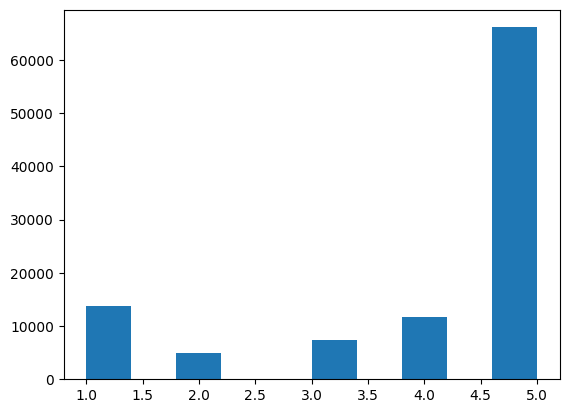

In [ ]:
df.stars.hist(grid=False)

Из результатов выше можно сделать следующие выводы:

*   Шкала оценки варьируется от 1 звезды до 5. 

*   Оценки не сбалансированы. Пользователи чаще всего оставляют сугубо положительные отзывы.

*   В данных присутствуют пропущенные значения.

# Предварительная обработка данных

В первую очередь необходимо выделить входные и выходные данные в наборе для сети.

Из всех полей необходимую смысловую нагрузку имеет только поле text.

Целевым полем же является поле stars, так как именно оно определяет тональность текста.

In [ ]:
df = df.drop(["date", "name", "X", "Y", "status"], axis=1)
df

,stars,text
1,2.0,Были на экскурсии. Я очень люблю производствен...
2,5.0,"Часто ходим в это кафе. Красивый интерьер, оче..."
3,5.0,Вкусное мороженое. С кофе и яблочным пирогом с...
4,5.0,"Хорошее мороженное, разнообразие выбора и вкус..."
5,1.0,Ставлю одну звезду лишь за вкусное мороженое. ...
...,...,...
103909,1.0,"Зашли покурить кальян, попить чаю. Заказали ка..."
103910,4.0,"Мне понравилось. Быстро подошла официантка, бы..."
103911,5.0,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил..."
103912,5.0,"Госпади, как же тут вкусно готовят из простых ..."


In [ ]:
df = df.rename(columns={"text": "data", "stars": "target"})
df

,target,data
1,2.0,Были на экскурсии. Я очень люблю производствен...
2,5.0,"Часто ходим в это кафе. Красивый интерьер, оче..."
3,5.0,Вкусное мороженое. С кофе и яблочным пирогом с...
4,5.0,"Хорошее мороженное, разнообразие выбора и вкус..."
5,1.0,Ставлю одну звезду лишь за вкусное мороженое. ...
...,...,...
103909,1.0,"Зашли покурить кальян, попить чаю. Заказали ка..."
103910,4.0,"Мне понравилось. Быстро подошла официантка, бы..."
103911,5.0,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил..."
103912,5.0,"Госпади, как же тут вкусно готовят из простых ..."


Так как пропущенных значений относительно мало, строки с ними можно убрать из набора данных.

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isna().sum()

target    0
data      0
dtype: int64

Так как оценки пользователей не сбалансированы, нужно сделать перебалансировку данных.

Для этого сначала группы отзывов были объеденены между собой следующим образом:

*   Любой отзыв с оценкой меньше 5 считается плохим отзывом.

*   Любой отзыв с оценкой равной 5 считается хорошим отзывом.

Данный выбор группировки является валидным, так как наблюдается четкий дисбаланс между 5-звездочными оценками и другими, а также распространенной привычкой пользователей закрывать глаза на мелкие погрешности, что ведет к необъективным оценкам и ситуациям, когда объективное "значение" 4 звезд равно 3 и менее, тогда как 5 звезд могут покрывать весь диапазон "хороших" оценок - 4 и 5.

In [ ]:
df.target = df.target.replace({1: "bad", 2: "bad", 3: "bad", 4: "bad", 5: "good"})
df

,target,data
0,bad,Были на экскурсии. Я очень люблю производствен...
1,good,"Часто ходим в это кафе. Красивый интерьер, оче..."
2,good,Вкусное мороженое. С кофе и яблочным пирогом с...
3,good,"Хорошее мороженное, разнообразие выбора и вкус..."
4,bad,Ставлю одну звезду лишь за вкусное мороженое. ...
...,...,...
103868,bad,"Зашли покурить кальян, попить чаю. Заказали ка..."
103869,bad,"Мне понравилось. Быстро подошла официантка, бы..."
103870,good,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил..."
103871,good,"Госпади, как же тут вкусно готовят из простых ..."


Так как сети не могут работать с категориальными данными, необходимо закодировать целевое поле.

In [ ]:
label_encoder = LabelEncoder()
df.target = label_encoder.fit_transform(df.target)
df

,target,data
0,0,Были на экскурсии. Я очень люблю производствен...
1,1,"Часто ходим в это кафе. Красивый интерьер, оче..."
2,1,Вкусное мороженое. С кофе и яблочным пирогом с...
3,1,"Хорошее мороженное, разнообразие выбора и вкус..."
4,0,Ставлю одну звезду лишь за вкусное мороженое. ...
...,...,...
103868,0,"Зашли покурить кальян, попить чаю. Заказали ка..."
103869,0,"Мне понравилось. Быстро подошла официантка, бы..."
103870,1,"Очень вкусно, турецкая атмосфера🇹🇷Все понравил..."
103871,1,"Госпади, как же тут вкусно готовят из простых ..."


In [ ]:
df.target.hist(bins=2)

Так как дисбаланс до сих пор сохранился - хороших отзывов практически в два раза больше плохих - можно применить пересэмплирование.

In [25]:
df = df.append(df[df.target == 0], ignore_index=True)

<ipython-input-25-e85610b831ad>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df[df.target == 0], ignore_index=True)


<Axes: >

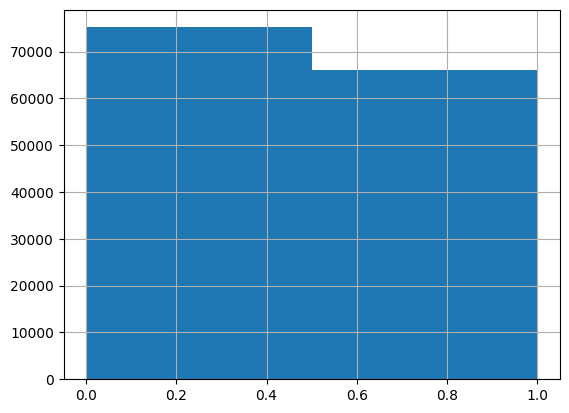

In [26]:
df.target.hist(bins=2)

Также необходимо провести предобработку текста, а именно:

1.  Убрать все знаки пунктуации как не несущие смысловой нагрузки элементы

2.  Привести все символы к нижнему регистру

3.  Удалить стоп-слова как не несущие смысловой нагрузки элементы

4.  Удалить несловарные слова, как имеющие ошибку в написании

5.  Привести все оставшиеся слова к их лемме

In [ ]:
df.data = df.data.str.lower().replace(r"[^а-я]", " ", regex=True)
df

,target,data
0,0,были на экскурсии я очень люблю производствен...
1,1,часто ходим в это кафе красивый интерьер оче...
2,1,вкусное мороженое с кофе и яблочным пирогом с...
3,1,хорошее мороженное разнообразие выбора и вкус...
4,0,ставлю одну звезду лишь за вкусное мороженое ...
...,...,...
141593,0,заказали кальян хотели посидеть расслабиться ...
141594,0,персонал не вежливый сказали все есть из меню...
141595,0,зашли покурить кальян попить чаю заказали ка...
141596,0,мне понравилось быстро подошла официантка бы...


In [ ]:
def lemmatize(words):
  lemmatized_words = []
  for word in word_tokenize(words):
    if word not in stop_words:
      parse = morph_analyzer.parse(word)[0]
      if parse.is_known and parse.normal_form not in stop_words:
        lemmatized_words.append(parse.normal_form)
  return " ".join(lemmatized_words)

stop_words = stopwords.words('russian')
morph_analyzer = MorphAnalyzer()

df.data  = df.data.apply(lemmatize)
lem_df = df.copy(deep=True)
df

,target,data
0,0,экскурсия очень любить производственный экскур...
1,1,часто ходить это кафе красивый интерьер очень ...
2,1,вкусный мороженое кофе яблочный пирог мятый об...
3,1,хороший мороженный разнообразие выбор вкус веж...
4,0,ставить звезда лишь вкусный мороженое отсутств...
...,...,...
141593,0,заказать кальян хотеть посидеть расслабиться и...
141594,0,персонал вежливый сказать меню весь выпечка ко...
141595,0,заслать покурить кальян попить чай заказать ка...
141596,0,понравиться быстро подойти официантка быстро п...


Для векторизации текста необходимо:

1.  Составить словарь вида токен: число, где токен - это уникальное слово или специальный тег: \<PAD> - тег для отступа, \<UNK> - тег для неизвестного токена

2.  Вычислить длину наибольшего отзыва по количеству слов

3.  Преобразовать каждое слово в отзыве в число с помощью словаря и дополнить его тегом \<PAD> до нужной длины

In [32]:
words = ['<PAD>', '<UNK>'] + list(set(word for review in df.data for word in word_tokenize(review)))
word2vec = defaultdict(lambda: 1, {word: i for i, word in enumerate(words)})
longest_review = df.data.str.split().apply(len).max()

In [33]:
longest_review, len(words)

(742, 26343)

In [34]:
def vectorize(review):
  vector = [0] * longest_review
  for i, word in enumerate(word_tokenize(review)):
    vector[i] = word2vec[word]
  return torch.tensor(vector, dtype=torch.long)

In [35]:
df.data = pd.Series(list(map(vectorize, df.data.to_list())))
df

,target,data
0,0,"[tensor(21641), tensor(25455), tensor(3264), t..."
1,1,"[tensor(21736), tensor(6336), tensor(11060), t..."
2,1,"[tensor(29), tensor(12829), tensor(5615), tens..."
3,1,"[tensor(20701), tensor(8950), tensor(25289), t..."
4,0,"[tensor(8300), tensor(21869), tensor(6141), te..."
...,...,...
141254,0,"[tensor(14613), tensor(5632), tensor(18920), t..."
141255,0,"[tensor(17273), tensor(16581), tensor(12740), ..."
141256,0,"[tensor(10811), tensor(11832), tensor(5632), t..."
141257,0,"[tensor(21123), tensor(12922), tensor(2985), t..."


In [36]:
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

((113007, 2), (28252, 2))

In [37]:
class CustomDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
     return self.X[index], self.y[index]

In [38]:
trainset = CustomDataset(train.data.to_list(), train.target.to_list())
testset = CustomDataset(test.data.to_list(), test.target.to_list())

In [39]:
trainloader = DataLoader(trainset, batch_size=ceil(len(train)/NUM_BATCHES), shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=trainloader.batch_size, drop_last=True)

# Создание и обучение моделей

Существуют несколько подходов к классификации текстов, в данной работе будут рассмотрены следующие:

1.  Многослойный перцептрон.

2.  Сверточная сеть.

3.  Реккурентная сеть с долгой краткосрочной паматью.

## MLP

In [81]:
class MLP(nn.Module):

    def __init__(self, num_embeddings: int, embedding_dim: int, out_features: int):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.AdaptiveAvgPool1d(8),
            nn.Flatten(1),
            nn.Linear(embedding_dim * 8, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, out_features),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        inputs = self.embedding(inputs)
        inputs = inputs.reshape(inputs.size(0), inputs.size(2), inputs.size(1))
        return self.model(inputs).squeeze().to(torch.float)


In [82]:
torch.cuda.empty_cache()
mlp = MLP(
        num_embeddings=len(word2vec),
        embedding_dim=64,
        out_features=1
).to(DEVICE)
loss_func = nn.BCELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
mlp

MLP(
  (embedding): Embedding(26343, 64)
  (model): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): AdaptiveAvgPool1d(output_size=8)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [83]:
mlp.train()
mlp_losses = []
mlp_time = []
for epoch in range(EPOCHS):
  start = time.time()
  losses_sum = 0
  for X, y in trainloader:
    optimizer.zero_grad()
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = mlp(X)
    loss_val = loss_func(pred, y)
    loss_val.backward()
    losses_sum += loss_val.cpu().item()
    optimizer.step()
  mlp_time.append(time.time() - start)
  mlp_losses.append(losses_sum / NUM_BATCHES)
  print(f"{epoch = }; loss = {mlp_losses[-1]}; time = {mlp_time[-1]}")

epoch = 0; loss = 0.6538938760757447; time = 3.1529276371002197
epoch = 1; loss = 0.6401555925607681; time = 3.0440471172332764
epoch = 2; loss = 0.6239594519138336; time = 3.144496202468872
epoch = 3; loss = 0.6039146840572357; time = 2.953632354736328
epoch = 4; loss = 0.5738534271717072; time = 3.051687240600586
epoch = 5; loss = 0.5357314676046372; time = 2.9960432052612305
epoch = 6; loss = 0.5027344852685929; time = 2.9532158374786377
epoch = 7; loss = 0.47802773863077164; time = 2.93326997756958
epoch = 8; loss = 0.45726158767938613; time = 2.9153201580047607
epoch = 9; loss = 0.4428979054093361; time = 3.0455374717712402
epoch = 10; loss = 0.4286944195628166; time = 2.9402525424957275
epoch = 11; loss = 0.417801171541214; time = 2.916053295135498
epoch = 12; loss = 0.4085328206419945; time = 2.904872179031372
epoch = 13; loss = 0.39969653338193895; time = 2.970712661743164
epoch = 14; loss = 0.3886817008256912; time = 2.9993226528167725
epoch = 15; loss = 0.383426833152771; tim

In [84]:
mlp.eval()
mlp_correct_pred = 0
mlp_preds = []
with torch.no_grad():
  for X, y in testloader:
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = mlp(X).round()
    mlp_preds.append(pred.cpu())
    mlp_correct_pred += (pred == y).type(torch.float).sum().item()

## CNN

In [85]:
class CNN(nn.Module):

    def __init__(self, num_embeddings: int, embedding_dim: int, out_features: int):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=2),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.AdaptiveAvgPool1d(8),
            nn.Flatten(1),
            nn.Linear(128 * 8, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, out_features),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        inputs = self.embedding(inputs)
        inputs = inputs.reshape(inputs.size(0), inputs.size(2), inputs.size(1))
        return self.model(inputs).squeeze().to(torch.float)


In [87]:
torch.cuda.empty_cache()
cnn = CNN(
        num_embeddings=len(word2vec),
        embedding_dim=64,
        out_features=1
).to(DEVICE)
loss_func = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
cnn

CNN(
  (embedding): Embedding(26343, 64)
  (model): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): AdaptiveAvgPool1d(output_size=8)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=512, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [88]:
cnn.train()
cnn_losses = []
cnn_time = []
for epoch in range(EPOCHS):
  start = time.time()
  losses_sum = 0
  for X, y in trainloader:
    optimizer.zero_grad()
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = cnn(X)
    loss_val = loss_func(pred, y)
    loss_val.backward()
    losses_sum += loss_val.cpu().item()
    optimizer.step()
  cnn_time.append(time.time() - start)
  cnn_losses.append(losses_sum / NUM_BATCHES)
  print(f"{epoch = }; loss = {cnn_losses[-1]}; time = {cnn_time[-1]}")

epoch = 0; loss = 0.7407673746347427; time = 10.837454795837402
epoch = 1; loss = 0.6587369561195373; time = 10.80471134185791
epoch = 2; loss = 0.6567396998405457; time = 10.881208896636963
epoch = 3; loss = 0.6562427967786789; time = 10.648769617080688
epoch = 4; loss = 0.6559090048074723; time = 10.618218421936035
epoch = 5; loss = 0.6550338923931122; time = 10.59866213798523
epoch = 6; loss = 0.6525653928518296; time = 10.694139957427979
epoch = 7; loss = 0.6445324629545212; time = 10.698091745376587
epoch = 8; loss = 0.6305309206247329; time = 10.653876304626465
epoch = 9; loss = 0.5991111308336258; time = 10.697305679321289
epoch = 10; loss = 0.5307719975709915; time = 10.625916719436646
epoch = 11; loss = 0.4698692440986633; time = 10.713754892349243
epoch = 12; loss = 0.4364227667450905; time = 10.849587678909302
epoch = 13; loss = 0.4133502423763275; time = 10.631300449371338
epoch = 14; loss = 0.4019493222236633; time = 10.703544616699219
epoch = 15; loss = 0.389000141620636;

In [89]:
cnn.eval()
cnn_correct_pred = 0
cnn_preds = []
with torch.no_grad():
  for X, y in testloader:
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = cnn(X).round()
    cnn_preds.append(pred.cpu())
    cnn_correct_pred += (pred == y).type(torch.float).sum().item()

## LSTM

In [90]:
class LSTM(nn.Module):

    def __init__(self, num_embeddings: int, embedding_dim: int, hidden_dim: int, vector_size: int, layers: int, out_features: int):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layers, batch_first=True)
        self.h = None
        self.c = None
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(hidden_dim * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, out_features),
            nn.Sigmoid()
        )


    def forward(self, inputs):
        if self.h is not None and self.c is not None:
          hc = self.h, self.c
        else:
          hc = None
        out = self.embedding(inputs)
        out, (h, c) = self.lstm(out, (hc))
        self.h = h.detach()
        self.c = c.detach()
        out = self.model(out)
        return out.squeeze().to(torch.float)


In [92]:
torch.cuda.empty_cache()
lstm = LSTM(
        num_embeddings=len(word2vec),
        embedding_dim=64,
        hidden_dim=8,
        vector_size=longest_review,
        layers=2,
        out_features=1
).to(DEVICE)
loss_func = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
lstm

LSTM(
  (embedding): Embedding(26343, 8)
  (lstm): LSTM(8, 8, num_layers=2, batch_first=True)
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5936, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [93]:
lstm.train()
lstm_losses = []
lstm_time = []
for epoch in range(EPOCHS):
  start = time.time()
  losses_sum = 0
  for X, y in trainloader:
    optimizer.zero_grad()
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = lstm(X)
    loss_val = loss_func(pred, y)
    loss_val.backward()
    losses_sum += loss_val.cpu().item()
    optimizer.step()
  lstm_time.append(time.time() - start)
  lstm_losses.append(losses_sum / NUM_BATCHES)
  print(f"{epoch = }; loss = {lstm_losses[-1]}; time = {lstm_time[-1]}")

epoch = 0; loss = 0.6764530956745147; time = 4.648126125335693
epoch = 1; loss = 0.6567416697740555; time = 4.473607778549194
epoch = 2; loss = 0.6544009625911713; time = 4.499146223068237
epoch = 3; loss = 0.6475336968898773; time = 4.562485218048096
epoch = 4; loss = 0.6332640051841736; time = 4.564523935317993
epoch = 5; loss = 0.6202746897935867; time = 4.620403289794922
epoch = 6; loss = 0.5940916210412979; time = 4.715224266052246
epoch = 7; loss = 0.5508635997772217; time = 4.61276650428772
epoch = 8; loss = 0.5200431734323502; time = 4.588332891464233
epoch = 9; loss = 0.49220157265663145; time = 4.618497610092163
epoch = 10; loss = 0.4702621713280678; time = 4.557374477386475
epoch = 11; loss = 0.45056323111057284; time = 4.542475461959839
epoch = 12; loss = 0.4363604709506035; time = 4.550215482711792
epoch = 13; loss = 0.42424529045820236; time = 4.515284061431885
epoch = 14; loss = 0.4159305065870285; time = 4.554821014404297
epoch = 15; loss = 0.4076408386230469; time = 5.

In [94]:
lstm.eval()
lstm_correct_pred = 0
lstm_preds = []
with torch.no_grad():
  for X, y in testloader:
    X, y = X.to(torch.long).to(DEVICE), y.to(torch.float).to(DEVICE)
    pred = lstm(X).round()
    lstm_preds.append(pred.cpu())
    lstm_correct_pred += (pred == y).type(torch.float).sum().item()

# Сравнение эффективностей моделей

,Test accuracy,F1 Weighted,F1 Macro,F1 Micro,Average Time
mlp,0.691278,0.864185,0.863801,0.864006,2.97291
cnn,0.679279,0.848845,0.848985,0.849009,10.670099
lstm,0.688659,0.860888,0.860374,0.860733,4.628037


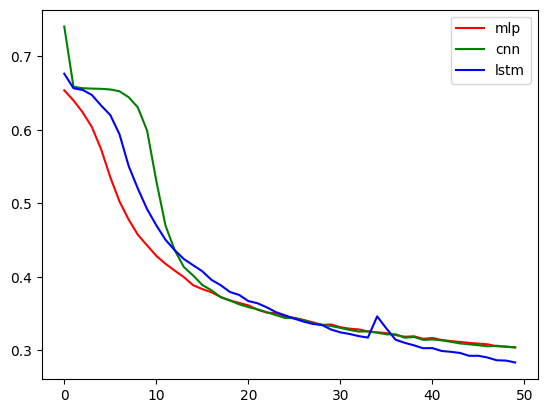

In [97]:
labels = ['mlp', 'cnn', 'lstm']
losses = [mlp_losses, cnn_losses, lstm_losses]
preds = [torch.cat(mlp_preds), torch.cat(cnn_preds), torch.cat(lstm_preds)]
correct_preds = [mlp_correct_pred, cnn_correct_pred, lstm_correct_pred]
times = [mlp_time, cnn_time, lstm_time]
colors = ['r', 'g', 'b']
comparison_chart = pd.DataFrame([], columns=['Test accuracy', 'F1 Weighted', 'F1 Macro', 'F1 Micro', 'Average Time'], index=labels)
for i in range(3):
  plt.plot(range(len(losses[i])), losses[i], c=colors[i], label=labels[i])
  comparison_chart.iloc[i, :] = [
      correct_preds[i] / len(testset.y),
      f1_score(testset.y[:preds[i].size()[0]], preds[i], average="weighted"),
      f1_score(testset.y[:preds[i].size()[0]], preds[i], average="macro"),
      f1_score(testset.y[:preds[i].size()[0]], preds[i], average="micro"),
      sum(times[i]) / len(times[i])
  ]

plt.legend()

comparison_chart

Исходя из данных, полученных выше, можно сделать вывод:

*   Все три модели относительно равны судя по метрикам, вычисленным выше, за исключением сверточной нейронной сети, так как среднее время прохождения одной эпохи в 2.5 раза больше аналогичного у рекурретной сети с долгой краткосрочной памятью и в 5 раз больше, чем у многослойного перцептрона.

*   Если предпологать, что эпох будет, то анализируя графики обучения сетей и прогнозируя их будущее поведение, можно сделать предположение, что рекурретный вариант сети достигнет значительно большей эффективности относительно других вариантов сетей.

